In [16]:
!pip install -U tensorflow-addons
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import math
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
tf.config.run_functions_eagerly(True)

In [19]:
def Resnet_preprocess(x):
    #return tf.keras.applications.xception.preprocess_input(x)
    return tf.keras.applications.resnet50.preprocess_input(x)

In [ ]:
! cp /content/drive/MyDrive/FaceNet/lfw-deepfunneled-aligned.tgz .
! tar -xvzf lfw-deepfunneled-aligned.tgz

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "lfw-deepfunneled-aligned",
  seed=123,
  image_size=(112, 112),
  batch_size=100)

Found 13589 files belonging to 5749 classes.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [8]:
def get_model():

    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape = (112, 112, 3))

    # Freeze the base model
    base_model.trainable = False
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Dense(512,activation=None))
    model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
    return model

def get_modelx():
    
    base_model = tf.keras.applications.Xception(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(112, 112, 3),
            include_top=False) 

    # Freeze the base model
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(112, 112, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.Dense(512,activation=None)(x)
    outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [9]:
model = get_model()

94765736/94765736 [==============================] - 5s 0us/step


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 lambda (Lambda)             (None, 512)               0         
                                                        

In [11]:
print(model.layers[:-1][0])

In [12]:
for layer in model.layers[:-1]:
  print(layer)

In [ ]:
layer = model.layers[:-1][0]
layer_weights_values = layer.get_weights()
print(layer_weights_values)

In [ ]:
#to load a existing weight file and continue training
epochs = 0
reg_coef = 1.0

file_name = '/content/drive/MyDrive/FaceNet/checkpoint/tripletloss/model_weights_'
file_number = 1
file_name = file_name + str(file_number*epochs)+ '_epochs'
model = tf.keras.models.load_model(file_name)
print(file_name)

In [21]:
# Instantiate an optimizer to train the model.
lr = 0.001
optimizer = tf.keras.optimizers.Adam(lr)

In [22]:
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tfa.losses.TripletSemiHardLoss())

In [26]:
from keras.callbacks import Callback
class WeightsSaver(Callback):
  def __init__(self, N):
    self.N = N
    self.epoch = 0

  def on_epoch_end(self, epoch, logs={}):
    if self.epoch % self.N == 0:
      file_name = '/content/drive/MyDrive/FaceNet/checkpoint/model_weights_'
      file_name = file_name + str(self.epoch)+ '_epochs'
      model.save(file_name)
      name = 'weights%08d.h5' % self.epoch
      self.model.save_weights(name)
    self.epoch += 1

In [27]:
epochs = 10
reg_coef = 1.0
file_number = 0

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[WeightsSaver(1)])

Epoch 1/10
136/136 [==============================] - ETA: 0s - loss: 0.9474

136/136 [==============================] - 68s 497ms/step - loss: 0.9474
Epoch 2/10
136/136 [==============================] - ETA: 0s - loss: 0.9446

136/136 [==============================] - 69s 508ms/step - loss: 0.9446
Epoch 3/10
136/136 [==============================] - ETA: 0s - loss: 0.9101

136/136 [==============================] - 68s 497ms/step - loss: 0.9101
Epoch 4/10
136/136 [==============================] - ETA: 0s - loss: 0.8873

136/136 [==============================] - 68s 503ms/step - loss: 0.8873
Epoch 5/10
136/136 [==============================] - ETA: 0s - loss: 0.8557

136/136 [==============================] - 69s 504ms/step - loss: 0.8557
Epoch 6/10
136/136 [==============================] - ETA: 0s - loss: 0.8571

136/136 [==============================] - 68s 500ms/step - loss: 0.8571
Epoch 7/10
136/136 [==============================] - ETA: 0s - loss: 0.8371

136/136 [==============================] - 68s 503ms/step - loss: 0.8371
Epoch 8/10
136/136 [==============================] - ETA: 0s - loss: nan

136/136 [==============================] - 68s 498ms/step - loss: nan
Epoch 9/10
136/136 [==============================] - ETA: 0s - loss: nan

136/136 [==============================] - 69s 507ms/step - loss: nan
Epoch 10/10
136/136 [==============================] - ETA: 0s - loss: nan

136/136 [==============================] - 69s 505ms/step - loss: nan


In [28]:
print(history.history)

{'loss': [0.9473838210105896, 0.9445924758911133, 0.9101294279098511, 0.88733971118927, 0.8557479381561279, 0.8571360111236572, 0.8371464610099792, nan, nan, nan]}


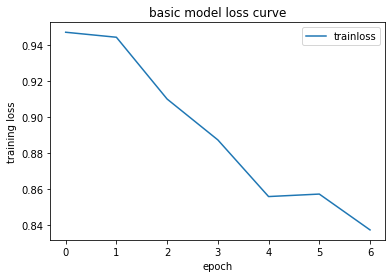

In [29]:
plt.plot(history.history['loss'])
plt.title('basic model loss curve')
plt.ylabel('training loss')
plt.xlabel('epoch')
plt.legend(['trainloss'], loc='upper right')
plt.show()